In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv('../../data/Final_divorcio_denuncia.csv')
df.head()


,Departamento,año,Denuncias,Divorcios,Sexo_hombre,Sexo_mujer,0 a 4,5 a 9,10 a 14,15 a 19,...,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad
0,Guatemala,2008,"5,117","1,052",494,"4,623",3,9,28,353,...,752,629,445,308,191,127,73,46,78,52
1,Guatemala,2009,"6,692","1,140",634,"6,058",6,9,44,549,...,"1,237","1,030",763,494,336,208,124,84,151,70
2,Guatemala,2010,"5,792","1,561",517,"5,275",6,9,36,478,...,992,873,614,402,267,161,98,68,121,53
3,Guatemala,2011,"6,122","1,798",531,"5,591",6,8,38,520,...,"1,060",948,698,440,299,189,114,80,143,74
4,Guatemala,2012,"6,911","2,152",568,"6,343",4,16,49,679,...,"1,374","1,224",886,563,357,236,141,97,177,93


# Limpieza de datos

In [30]:
# Eliminar filas de totales nacionales si existen
df = df[df['Departamento'] != 'República']

# Reemplazar comas por nada y convertir a entero
cols_numericas = df.columns.drop('Departamento')
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear la variable objetivo: "Categoria_Divorcios"
promedio_nacional = df['Divorcios'].mean()
df['Categoria_Divorcios'] = df['Divorcios'].apply(
    lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
)

In [31]:
# Verificar valores únicos
df['Categoria_Divorcios'].value_counts()

Categoria_Divorcios
bajo    322
alto     38
Name: count, dtype: int64

In [32]:
df.head()

,Departamento,año,Denuncias,Divorcios,Sexo_hombre,Sexo_mujer,0 a 4,5 a 9,10 a 14,15 a 19,...,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad,Categoria_Divorcios
0,Guatemala,2008,5117,1052,494,4623,3,9,28,353,...,629,445,308,191,127,73,46,78,52,alto
1,Guatemala,2009,6692,1140,634,6058,6,9,44,549,...,1030,763,494,336,208,124,84,151,70,alto
2,Guatemala,2010,5792,1561,517,5275,6,9,36,478,...,873,614,402,267,161,98,68,121,53,alto
3,Guatemala,2011,6122,1798,531,5591,6,8,38,520,...,948,698,440,299,189,114,80,143,74,alto
4,Guatemala,2012,6911,2152,568,6343,4,16,49,679,...,1224,886,563,357,236,141,97,177,93,alto


# Visualizacion de datos

                    año  Denuncias  Divorcios  Sexo_hombre  Sexo_mujer  \
año            1.000000   0.013347   0.114542     0.085418    0.004273   
Denuncias      0.013347   1.000000   0.927060     0.977802    0.999655   
Divorcios      0.114542   0.927060   1.000000     0.960241    0.920003   
Sexo_hombre    0.085418   0.977802   0.960241     1.000000    0.971962   
Sexo_mujer     0.004273   0.999655   0.920003     0.971962    1.000000   
 0  a  4       0.039407   0.949099   0.888688     0.937312    0.947608   
 5  a  9       0.058599   0.965624   0.920082     0.957978    0.963563   
10 a 14       -0.005357   0.982959   0.892998     0.941018    0.985141   
15 a 19       -0.034839   0.980108   0.868376     0.921779    0.984354   
20 a 24        0.011346   0.996036   0.916949     0.966080    0.996676   
25 a 29        0.020084   0.998357   0.927351     0.975374    0.998116   
30 a 34        0.022775   0.997857   0.928462     0.975011    0.997600   
35 a 39        0.038920   0.996657   0

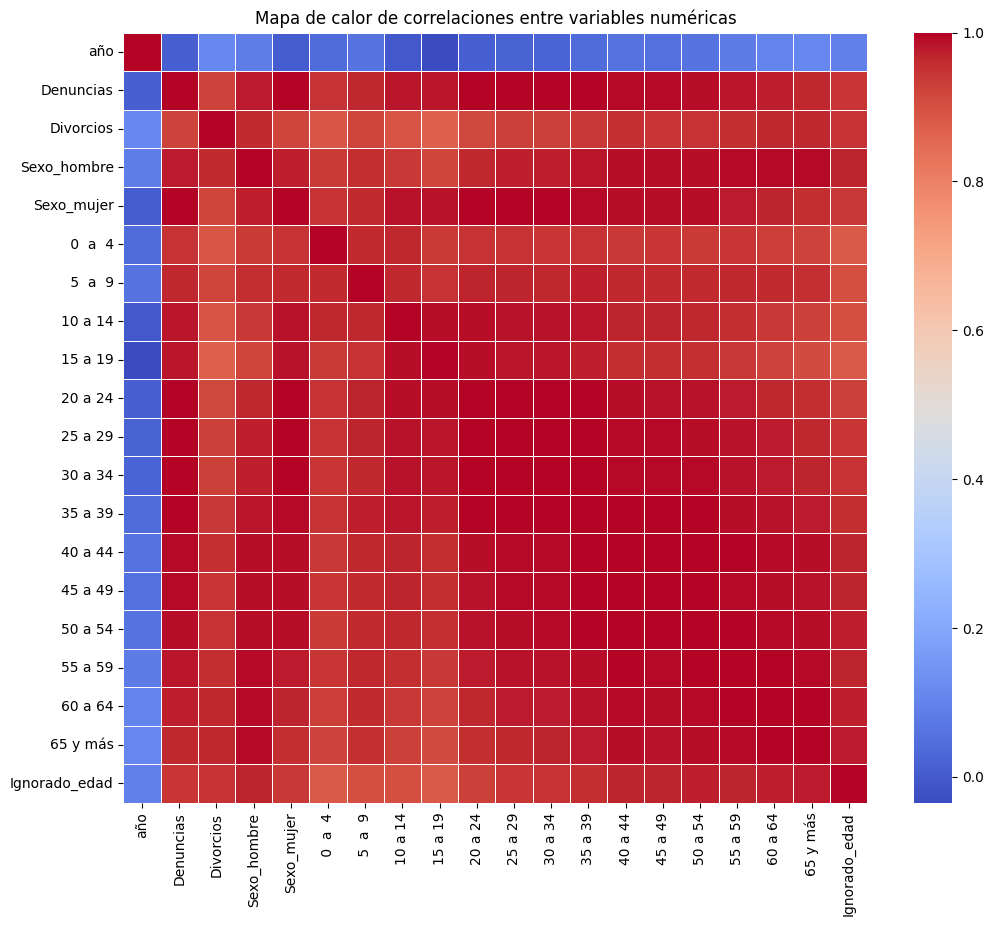

In [54]:
# Visualización: Mapa de calor de correlaciones
correlation_matrix = df[cols_numericas].corr()

print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

Este análisis revela una alta colinealidad entre los grupos etarios y otras variables poblacionales, lo cual es esperado

# Modelo SVM

## Buscar el mejor modelo

In [34]:
# Variables X e y
X = df.drop(columns=['Departamento', 'Categoria_Divorcios', 'Divorcios'])  # No usamos Divorcio porque define la etiqueta
y = df['Categoria_Divorcios']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la clase
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)


In [ ]:
from sklearn.model_selection import GridSearchCV

modelo = SVC()
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.01, 0.1, 1, 5, 16, 32],
    'gamma': ['scale', 'auto'],  
    'degree': [2, 3, 4],          
    'decision_function_shape': ['ovo', 'ovr']
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_accuracy = grid_search.score(X_test, y_test)
best_params = grid_search.best_params_

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

mejor_linear = cv_results_sorted[cv_results_sorted['param_kernel'] == 'linear'].iloc[0]
mejor_rbf = cv_results_sorted[cv_results_sorted['param_kernel'] == 'rbf'].iloc[0]
mejor_poly = cv_results_sorted[cv_results_sorted['param_kernel'] == 'poly'].iloc[0]

print("Mejor modelo LINEAR:")
print("Parámetros:", mejor_linear['params'])
print("Accuracy promedio:", mejor_linear['mean_test_score'])

print("\nMejor modelo RBF:")
print("Parámetros:", mejor_rbf['params'])
print("Accuracy promedio:", mejor_rbf['mean_test_score'])

print("\nMejor modelo POLY:")
print("Parámetros:", mejor_poly['params'])
print("Accuracy promedio:", mejor_poly['mean_test_score'])

Mejor modelo LINEAR:
Parámetros: {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
Accuracy promedio: 0.9721568627450982

Mejor modelo RBF:
Parámetros: {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy promedio: 0.968235294117647

Mejor modelo POLY:
Parámetros: {'C': 16, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Accuracy promedio: 0.9643921568627452


## Modelo Linear con parametros dados


In [45]:
svm_model = SVC(
    kernel='linear',
    C=1,
    gamma='auto',
    degree=2,
    decision_function_shape='ovo',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [46]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.98611111 0.91666667 0.95833333 0.94444444 0.91666667]
Promedio: 0.9444444444444444
Desviación estándar: 0.02635231383473653


### Evaluacion de modelo con matriz de confusion

Accuracy: 0.8703703703703703
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       0.43      0.91      0.59        11
        bajo       0.99      0.87      0.92        97

    accuracy                           0.87       108
   macro avg       0.71      0.89      0.76       108
weighted avg       0.93      0.87      0.89       108



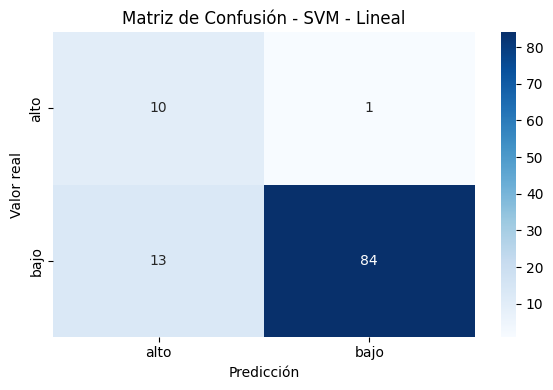

In [47]:
svm_model.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Lineal")
plt.tight_layout()
plt.show()


## Modelo gaussiano con parametros dados

In [48]:
svm_model_rbf = SVC(
    kernel='rbf',
    C=1,
    gamma='scale',
    degree=2,
    decision_function_shape='ovo',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [49]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model_rbf, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.95833333 0.93055556 0.94444444 0.94444444 0.91666667]
Promedio: 0.9388888888888889
Desviación estándar: 0.014163943093313305


### Evaluacion de modelo con matriz de confusion

Accuracy: 0.9259259259259259
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       0.59      0.91      0.71        11
        bajo       0.99      0.93      0.96        97

    accuracy                           0.93       108
   macro avg       0.79      0.92      0.84       108
weighted avg       0.95      0.93      0.93       108



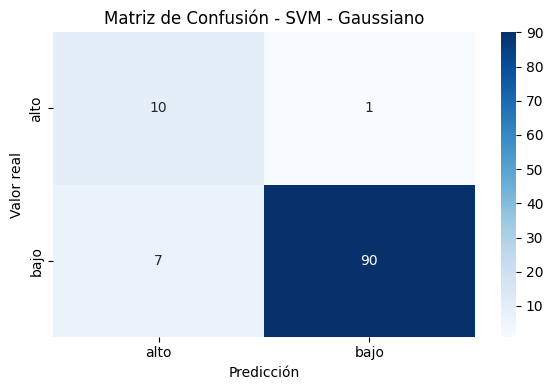

In [50]:
svm_model_rbf.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model_rbf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Gaussiano")
plt.tight_layout()
plt.show()


## Modelo Polinomial con parametros dados

In [51]:
svm_model_poly = SVC(
    kernel='poly',
    C=16,
    gamma='auto',
    degree=3,
    decision_function_shape='ovr',
    class_weight='balanced'
)


### Entrenamiento con validacion cruzada

In [52]:
# Validación cruzada estratificada 5-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model_poly, X_scaled, y_encoded, cv=cv, scoring='accuracy')

# Promedio y desviación estándar
scores_mean = np.mean(scores)
scores_std = np.std(scores)

print("Accuracies por fold:", scores)
print("Promedio:", scores_mean)
print("Desviación estándar:", scores_std)

Accuracies por fold: [0.95833333 0.97222222 0.95833333 0.98611111 0.95833333]
Promedio: 0.9666666666666666
Desviación estándar: 0.01111111111111111


### Evaluacion de modelo con matriz de confusion

Accuracy: 0.9537037037037037
Reporte de clasificación:
               precision    recall  f1-score   support

        alto       0.80      0.73      0.76        11
        bajo       0.97      0.98      0.97        97

    accuracy                           0.95       108
   macro avg       0.88      0.85      0.87       108
weighted avg       0.95      0.95      0.95       108



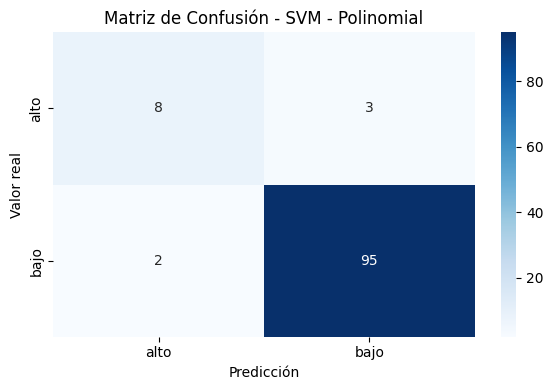

In [53]:
svm_model_poly.fit(X_train, y_train)

# Predicción y métricas
y_pred = svm_model_poly.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Reporte de clasificación:\n", report)

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión - SVM - Polinomial")
plt.tight_layout()
plt.show()


# Analisis de resultados

#### SVM Lineal
- Perfecta clasificación: 100% de precisión, recall y f1-score en ambas clases.
- Conclusión: El espacio de datos es linealmente separable; un margen óptimo basta para una frontera decisiva..

#### SVM RBF (Gaussiano)
- Igual rendimiento que el lineal, confirmando que el modelo puede adaptarse tanto a relaciones lineales como no lineales en este caso, aunque probablemente está ajustando sobre un problema que ya es fácilmente separable.

#### SVM Polinomial
- Problemas con la clase "alto": 3 de 12 fueron clasificadas incorrectamente como "bajo".
- Recall de "alto" = 75%, precision = 100% → sesgo hacia clase mayoritaria, sensibilidad menor.

# Conclusiones

1. Modelos Lineal y Gaussiano logran clasificación perfecta (100%), tanto en prueba como en validación cruzada.

2. El modelo Polinomial, aunque competente (97% accuracy), no supera a los otros y es más complejo, lo que puede inducir sobreajuste innecesario o reducir la interpretabilidad.

3. Las métricas confirman que los datos son altamente separables, y un SVM simple (lineal o rbf) es suficiente.